In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')


In [2]:
Dataset = pd.read_csv('Dataset.csv')


In [3]:
Dataset['Date'] = pd.to_datetime(Dataset.Date, format="%d-%m-%Y")


In [4]:
Data_Dine = Dataset[['Date', 'Dine In Amount']]
Data_Dine = Data_Dine.set_index('Date')
Data_Dine.head()


,Dine In Amount
Date,
2013-09-01,53722
2013-09-02,39137
2013-09-03,597
2013-09-04,0
2013-09-05,4999


In [5]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
           'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X


In [6]:
split_date_d = '01-Jan-2019'
Data_Dine_Train = Data_Dine.loc[Data_Dine.index <= split_date_d].copy()
Data_Dine_Test = Data_Dine.loc[Data_Dine.index > split_date_d].copy()


In [7]:
X_Train_D, Y_Train_D = create_features(Data_Dine_Train, label='Dine In Amount')
X_Test_D, Y_Test_D = create_features(Data_Dine_Test, label='Dine In Amount')


<ipython-input-5-7d898388bd09>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [8]:
XGB_D = xgb.XGBRegressor(n_estimators=1000)
XGB_D.fit(X_Train_D, Y_Train_D,
          eval_set=[(X_Train_D, Y_Train_D), (X_Test_D, Y_Test_D)],
          early_stopping_rounds=50,
          verbose=False)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

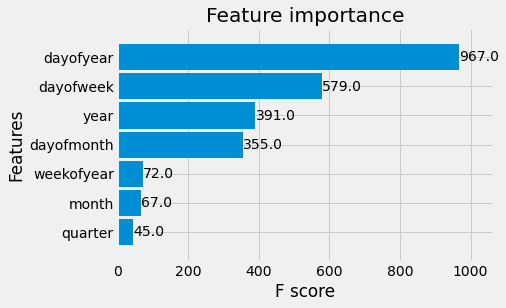

In [9]:
plot_importance(XGB_D, height=0.9)


In [10]:
Data_Dine_Test['Dine In Amount Prediction'] = XGB_D.predict(X_Test_D)
Data_Dine_all = pd.concat([Data_Dine_Test, Data_Dine_Train], sort=False)


<AxesSubplot:xlabel='Date'>

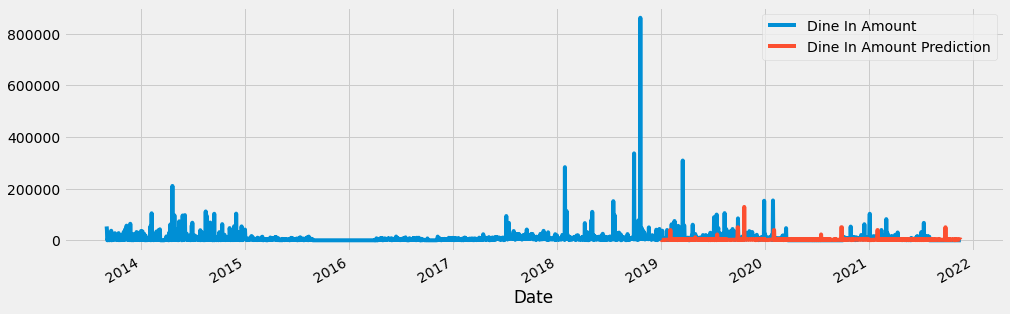

In [11]:
Data_Dine_all[['Dine In Amount', 'Dine In Amount Prediction']].plot(
    figsize=(15, 5))


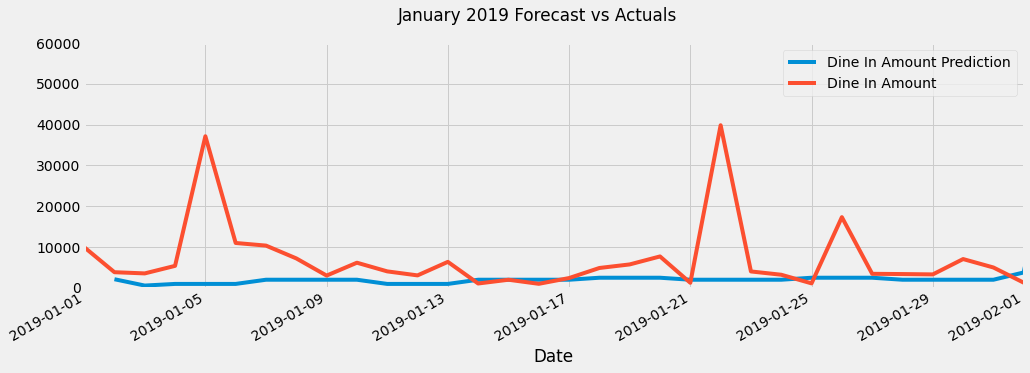

In [12]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
Data_Dine_all[['Dine In Amount Prediction', 'Dine In Amount']].plot(ax=ax,
                                                                    style=['-', '-'])
ax.set_xbound(lower='01-01-2019', upper='02-01-2019')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2019 Forecast vs Actuals')


In [13]:
mean_squared_error(y_true=Data_Dine_Test['Dine In Amount'],
                   y_pred=Data_Dine_Test['Dine In Amount Prediction'])


298274652.3731305

In [14]:
mean_absolute_error(y_true=Data_Dine_Test['Dine In Amount'],
                    y_pred=Data_Dine_Test['Dine In Amount Prediction'])


6769.573388950098

In [15]:
Data_Dine_Test['error'] = Data_Dine_Test['Dine In Amount'] - \
    Data_Dine_Test['Dine In Amount Prediction']
Data_Dine_Test['abs_error'] = Data_Dine_Test['error'].apply(np.abs)
error_by_day = Data_Dine_Test.groupby(['year', 'month', 'dayofmonth']) \
    .mean()[['Dine In Amount', 'Dine In Amount Prediction', 'error', 'abs_error']]


In [16]:
error_by_day.sort_values('error', ascending=True).head(10)


Dine In Amount  Dine In Amount Prediction  \
year month dayofmonth                                              
2019 10    20                    8823              129220.781250   
2021 9     26                       0               50467.175781   
2020 9     25                       0               50467.175781   
           26                       0               50467.175781   
           27                       0               50467.175781   
2019 9     27                    3224               50467.175781   
2021 1     30                    5002               39608.699219   
2019 2     3                     5445               39608.699219   
2020 2     2                     5979               39608.699219   
2019 2     2                     8553               39608.699219   

                               error      abs_error  
year month dayofmonth                                
2019 10    20         -120397.781250  120397.781250  
2021 9     26          -50467.175781   50467.175781  
2020 9     25          -50467.175781   50467.175781  
           26          -50467.175781   50467.175781  
           27          -50467.175781   50467.175781  
2019 9     27          -47243.175781   47243.175781  
2021 1     30          -34606.699219   34606.699219  
2019 2     3           -34163.699219   34163.699219  
2020 2     2           -33629.699219   33629.699219  
2019 2     2           -31055.699219   31055.699219

In [17]:

error_by_day.sort_values('abs_error', ascending=False).head(10)


Dine In Amount  Dine In Amount Prediction  \
year month dayofmonth                                              
2019 3     18                  308757                1977.782471   
2020 1     29                  154186                1977.782471   
2019 12    29                  153030                5631.114746   
     10    20                    8823              129220.781250   
     8     12                  105204                1792.841187   
2021 1     3                   102679                 950.471497   
2019 7     15                   99569                 542.420044   
           6                    89384                2388.368164   
           7                    86125                4891.965332   
2021 3     2                    81885                2101.785889   

                               error      abs_error  
year month dayofmonth                                
2019 3     18          306779.217529  306779.217529  
2020 1     29          152208.217529  152208.217529  
2019 12    29          147398.885254  147398.885254  
     10    20         -120397.781250  120397.781250  
     8     12          103411.158813  103411.158813  
2021 1     3           101728.528503  101728.528503  
2019 7     15           99026.579956   99026.579956  
           6            86995.631836   86995.631836  
           7            81233.034668   81233.034668  
2021 3     2            79783.214111   79783.214111

In [18]:
error_by_day.sort_values('abs_error', ascending=True).head(10)


,,,Dine In Amount,Dine In Amount Prediction,error,abs_error
year,month,dayofmonth,,,,
2019,1,15,1973,1977.782471,-4.782471,4.782471
2021,5,31,1989,1977.782471,11.217529,11.217529
2019,5,20,2011,1977.782471,33.217529,33.217529
2021,5,27,2017,1977.782471,39.217529,39.217529
2019,7,30,1836,1792.841187,43.158813,43.158813
2021,2,25,2027,1977.782471,49.217529,49.217529
2019,2,6,1926,1977.782471,-51.782471,51.782471
2020,3,12,1895,1977.782471,-82.782471,82.782471
2019,3,5,1877,1977.782471,-100.782471,100.782471
